Number of connected components: 64


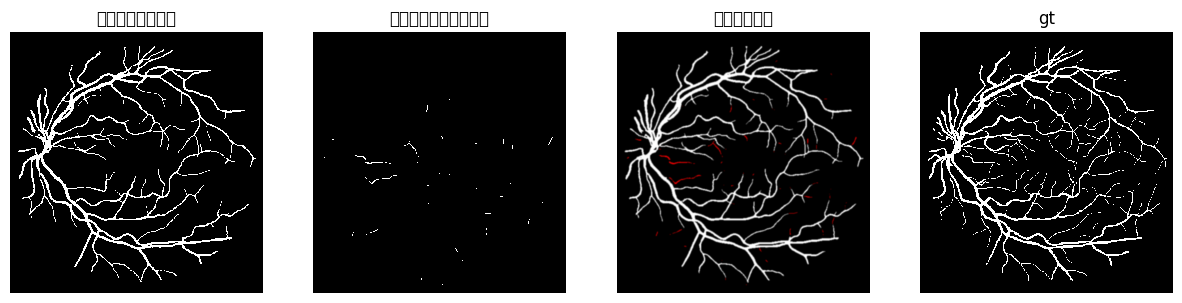

After: Number of connected components: 2


In [7]:
'''
单个去除孔洞，并保存
'''
from matplotlib import pyplot as plt
import numpy as np
import cc3d
import numpy as np
from PIL import Image

def twod(src):
    img = Image.open(src)
    return np.array(img) if len(np.array(img).shape) == 2 else np.array(img)[:,:,0]

# 将连通分量中数量小于20的索引全部找出来,然后将原始图像中对应位置的像素值设置为0,来去掉团。写一个函数
def remove_small_components(image,labels_out, min_size):
    #对image进行二值化，同时后续还需要设置红色（有这个需求，所以是0或1还是0-255需要你来判断）
    np_pred = np.where(image >= 0.5, 1., 0.)  # 0.5 thresholding
    np_pred = (np_pred * 255.).astype(np.uint8)
    image_with_removed_labels = np.copy(np_pred)
    image_with_other_labels = np.copy(np_pred)
    image_with_red_labels = np.copy(np_pred)

    unique_labels, counts = np.unique(labels_out, return_counts=True) #（[1,2],[100,200]）
    # 这会创建一个与 counts 长度相同的布尔数组
    # 这使用布尔索引从 unique_labels 中选择那些对应布尔数组 (counts < min_size) 中为 True 的元素
    remove_labels = unique_labels[counts < min_size] 
    # 这个函数会生成一个与 labels_out 形状相同的布尔数组，其中每个元素表示 labels_out 中对应位置的值是否在 remove_labels 中
    image_with_removed_labels[np.isin(labels_out, remove_labels)] = 0
    # remove_labels作为拓扑失败点的一部分
    image_with_other_labels[~np.isin(labels_out, remove_labels)] = 0
    # 将要去除的部分设置为红色
    red_color = [255, 0, 0]  # 红色
    image_with_red_labels = np.stack([image_with_red_labels]*3, axis=-1)  # 将灰度图像扩展为RGB图像
    image_with_red_labels[np.isin(labels_out, remove_labels)] = red_color
    return image_with_removed_labels, image_with_other_labels, image_with_red_labels




src = '/home/pxl/myProject/血管分割/molong-work/simple-unet-2d/inference-output/topo/pred_01.png'
srcGT = '/home/pxl/myProject/血管分割/molong-work/simple-unet-2d/inference-output/topo/gt_01.png'
image = twod(src)
gt = twod(srcGT)
gt = (gt * 255).astype(np.uint8) 

# 进行连通分量分析
# labels_out 是一个与输入图像相同维度的数组，每个连 通分量都会被赋予一个唯一的标签（整数值），代表它所属的连通分量。
# numcomp 是连通分量的总数，表示在图像中找到的连通分量的数量。
labels_out, numcomp = cc3d.connected_components(image, connectivity=8, return_N=True) # 26-connected

print(f"Number of connected components: {numcomp}")

# 将连通分量中数量小于20的索引全部找出来,然后将原始图像中对应位置的像素值设置为0,来去掉团。写一个函数
imageRemoved, imageOther, imageRed = remove_small_components(image, labels_out, 160)

# 把image保存在
plt.imsave('/home/pxl/myProject/血管分割/molong-resource/pred_孔洞处理后的.png', imageRemoved, cmap='gray')
plt.imsave('/home/pxl/myProject/血管分割/molong-resource/pred_去除的拓扑失败点.png', imageOther, cmap='gray')
plt.imsave('/home/pxl/myProject/血管分割/molong-resource/pred_去除部分标红.png', imageRed)

fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].imshow(imageRemoved, cmap='gray', interpolation='none', vmin=0, vmax=255)
axs[0].set_title('孔洞处理后的图像')
axs[0].axis('off')
axs[1].imshow(imageOther, cmap='gray', interpolation='none', vmin=0, vmax=255)
axs[1].set_title('去除的拓扑失败点图像')
axs[1].axis('off')
axs[2].imshow(imageRed, interpolation='bicubic', vmin=0, vmax=255)
axs[2].set_title('去除部分标红')
axs[2].axis('off')
axs[3].imshow(gt, cmap='gray', interpolation='none')
axs[3].set_title('gt')
axs[3].axis('off')
plt.show()

labels_out2, numcomp2 = cc3d.connected_components(imageRemoved, connectivity=8, return_N=True) # 26-connected
print(f"After: Number of connected components: {numcomp2}")

In [ ]:
'''
测试去除后的指标,对比一组，来寻找最优的min_size
'''
import torch
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cc3d
import sys
import os
sys.path.append(os.path.abspath('/home/pxl/myProject/血管分割/molong-utils/指标metric'))
from molong_metric import dice_score, clDice, get_betti_error, accuracy

def twod(src):
    img = Image.open(src)
    return np.array(img) if len(np.array(img).shape) == 2 else np.array(img)[:,:,0]

def remove_small_components(image, min_size):
  labels_out, numcomp = cc3d.connected_components(image, connectivity=8, return_N=True) # 26-connected
  unique_labels, counts = np.unique(labels_out, return_counts=True) #（[1,2],[100,200]）
  # 这会创建一个与 counts 长度相同的布尔数组
  # 这使用布尔索引从 unique_labels 中选择那些对应布尔数组 (counts < min_size) 中为 True 的元素
  remove_labels = unique_labels[counts < min_size] 
  # 这个函数会生成一个与 labels_out 形状相同的布尔数组，其中每个元素表示 labels_out 中对应位置的值是否在 remove_labels 中
  image[np.isin(labels_out, remove_labels)] = 0
  return image

srcPred = '/home/pxl/myProject/血管分割/molong-resource/pred_3044_a1c1b64aade9f79e5c60.png' # 480*480
srcTrue = '/home/pxl/myProject/血管分割/molong-resource/true_3044_e03e0573e1ea98fe3f48.png' # 480*480
srcAfter10 = '/home/pxl/myProject/血管分割/molong-resource/10_pred_孔洞处理后的.png' # 480*480
srcAfter20 = '/home/pxl/myProject/血管分割/molong-resource/20_pred_孔洞处理后的.png' # 480*480
srcAfter40 = '/home/pxl/myProject/血管分割/molong-resource/40_pred_孔洞处理后的.png' # 480*480
srcAfter80 = '/home/pxl/myProject/血管分割/molong-resource/80_pred_孔洞处理后的.png' # 480*480
srcAfter160 = '/home/pxl/myProject/血管分割/molong-resource/160_pred_孔洞处理后的.png' # 480*480

imageTrue = twod(srcTrue)
images = {
    'srcPred': twod(srcPred),
    'srcAfter10': twod(srcAfter10),
    'srcAfter20': twod(srcAfter20),
    'srcAfter40': twod(srcAfter40),
    'srcAfter80': twod(srcAfter80),
    'srcAfter160': twod(srcAfter160),
  
}

metrics = {'dice':[], 'cldice':[], '0betti':[], 'accuracy': []}


for key, img in images.items():
  dice = dice_score(img, imageTrue)
  cldice = clDice(img, imageTrue)
  betti_acc = get_betti_error(img, imageTrue)
  acc = accuracy(img, imageTrue)
  
  
  metrics['dice'].append(dice)
  metrics['cldice'].append(cldice)
  metrics['0betti'].append(betti_acc)
  metrics['accuracy'].append(acc)
  
  print("{}: Dice {}; clDice {}; 0-dim Betti {}; accuracy {} \n".format(key, dice, cldice, betti_acc, acc))


In [ ]:
'''
测试去除后的指标,只测试一个
'''
import torch
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cc3d
import sys
import os
sys.path.append(os.path.abspath('/home/pxl/myProject/血管分割/molong-utils/指标metric'))
from molong_metric import dice_score, clDice, get_betti_error, accuracy

def twod(src):
    img = Image.open(src)
    return np.array(img) if len(np.array(img).shape) == 2 else np.array(img)[:,:,0]
z
def remove_small_components(image, min_size):
  labels_out, numcomp = cc3d.connected_components(image, connectivity=8, return_N=True) # 26-connected
  unique_labels, counts = np.unique(labels_out, return_counts=True) #（[1,2],[100,200]）
  # 这会创建一个与 counts 长度相同的布尔数组
  # 这使用布尔索引从 unique_labels 中选择那些对应布尔数组 (counts < min_size) 中为 True 的元素
  remove_labels = unique_labels[counts < min_size] 
  # 这个函数会生成一个与 labels_out 形状相同的布尔数组，其中每个元素表示 labels_out 中对应位置的值是否在 remove_labels 中
  image[np.isin(labels_out, remove_labels)] = 0
  return image

srcTask1Pred = '/home/pxl/myProject/血管分割/molong-work/simple-unet-2d/inference-output/topo/pred_01.png' # 480*480
srcTask1True = '/home/pxl/myProject/血管分割/molong-work/simple-unet-2d/inference-output/topo/gt_01.png' # 480*480


imageTask1True = twod(srcTask1True)
imageTask1Pred = twod(srcTask1Pred)

diceTask = dice_score(imageTask1Pred, imageTask1True)
cldiceTask = clDice(imageTask1Pred, imageTask1True)
betti_accTask = get_betti_error(imageTask1Pred, imageTask1True)
accTask = accuracy(imageTask1Pred, imageTask1True)
print("{}: Dice {}; clDice {}; 0-dim Betti {}; accuracy {} \n".format("其他任务", diceTask, cldiceTask, betti_accTask, accTask))


imageTask1After = remove_small_components(imageTask1Pred, 160)


# 其他任务srcTask1After
diceTask2 = dice_score(imageTask1After, imageTask1True)
cldiceTask2 = clDice(imageTask1After, imageTask1True)
betti_accTask2 = get_betti_error(imageTask1After, imageTask1True)
accTask2 = accuracy(imageTask1After, imageTask1True)
print("{}: Dice {}; clDice {}; 0-dim Betti {}; accuracy {} \n".format("其他任务srcTask1After", diceTask2, cldiceTask2, betti_accTask2, accTask2))#+

In [ ]:
'''
测试去除后的指标,对比一个批次实验结果，来看效果
'''
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import cc3d
import sys

# 添加指标计算模块的路径
sys.path.append(os.path.abspath('/home/pxl/myProject/血管分割/molong-utils/指标metric'))
from molong_metric import dice_score, clDice, get_betti_error, accuracy

def twod(src):
    img = Image.open(src)
    return np.array(img) if len(np.array(img).shape) == 2 else np.array(img)[:,:,0]

def remove_small_components(image, labels_out, min_size):
    unique_labels, counts = np.unique(labels_out, return_counts=True)
    remove_labels = unique_labels[counts < min_size]
    image[np.isin(labels_out, remove_labels)] = 0
    return image

def process_image(src):
    image = twod(src)
    labels_out, numcomp = cc3d.connected_components(image, connectivity=8, return_N=True)
    image2 = remove_small_components(image, labels_out, 5)
    return image2

def calculate_metrics(pred, gt):
    metrics = {}
    metrics['dice'] = dice_score(pred, gt)
    metrics['cldice'] = clDice(pred, gt)
    metrics['0betti'] = get_betti_error(pred, gt)
    metrics['accuracy'] = accuracy(pred, gt)
    print("Dice {}; clDice {}; 0-dim Betti {}; accuracy {} \n".format(metrics['dice'], metrics['cldice'], metrics['0betti'], metrics['accuracy']))    
    return metrics

# 文件夹路径
folder_path = '/home/pxl/myProject/血管分割/molong-work/simple-unet-2d/inference-output/topo'

# 获取所有预测图像和对应的真实图像，确保只识别 .png 文件
pred_files = sorted([f for f in os.listdir(folder_path) if f.startswith('pred_') and f.endswith('.png')])
gt_files = sorted([f for f in os.listdir(folder_path) if f.startswith('gt_') and f.endswith('.png')])

# 初始化指标
total_metrics0 = {'dice': [], 'cldice': [], '0betti': [], 'accuracy': []}
total_metricsAfter = {'dice': [], 'cldice': [], '0betti': [], 'accuracy': []}

# 遍历所有图像
for pred_file, gt_file in zip(pred_files, gt_files):
    pred_path = os.path.join(folder_path, pred_file)
    gt_path = os.path.join(folder_path, gt_file)
    
    pred_image = twod(pred_path)
    gt_image = twod(gt_path)
    
    # 原始：
    print('原始的图像指标：')
    metrics0 = calculate_metrics(pred_image, gt_image)
    # 处理后：
    After_image = process_image(pred_path)
    print('     处理后的图像指标：')
    metricsAfter = calculate_metrics(After_image, gt_image)
    
    for key in total_metrics0:
        total_metrics0[key].append(metrics0[key])
        total_metricsAfter[key].append(metricsAfter[key])

# 计算平均值
mean_metrics0 = {key: np.mean(values) for key, values in total_metrics0.items()}
mean_metricsAfter = {key: np.mean(values) for key, values in total_metricsAfter.items()}

# 打印平均值
print("原始 Average Metrics:")
for key, value in mean_metrics0.items():
    print(f"{key}: {value}")
print("处理后 After Average Metrics:")
for key, value in mean_metricsAfter.items():
    print(f"{key}: {value}")


Min pixel value: 0, Max pixel value: 255
uint8
(584, 565)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


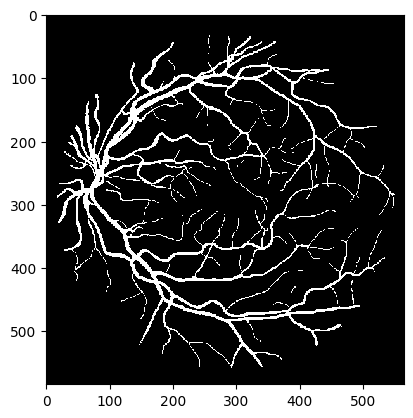

In [12]:
# 测试bug：（plt show显示会失真，本身数据是没问题）
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

def twod(src):
    img = Image.open(src)
    return np.array(img) if len(np.array(img).shape) == 2 else np.array(img)[:,:,0]

srcGT = '/home/pxl/myProject/血管分割/molong-work/simple-unet-2d/inference-output/topo/gt_01.png'
gt = twod(srcGT)

# 检查图像数据的最大和最小值
print(f"Min pixel value: {gt.min()}, Max pixel value: {gt.max()}")

# 如果图像数据已经是 uint8 且范围正确，不做多余操作
if gt.max() <= 1: 
    gt = (gt * 255).astype(np.uint8)
else:
    gt = gt.astype(np.uint8)

print(gt.dtype)
print(gt.shape)
print(gt)

# 使用 vmin 和 vmax 明确显示范围
plt.imshow(gt, cmap='gray', interpolation='none', vmin=0, vmax=255)
plt.imsave('/home/pxl/myProject/血管分割/molong-resource/测试gt_01.png', gt)
